# AT&T Spam Detector Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, GRU, SimpleRNN, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from wordcloud import WordCloud

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorboard.plugins.hparams import api as hp

## IMPORT DATA

In [2]:

try:
    df = pd.read_csv('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam.csv', encoding='latin1')
    print(df.head())
except UnicodeDecodeError as e:
    print(f"UnicodeDecodeError: {e}")


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


## EXPLORE DATA

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


There are 3 useless columns that we should remove.

In [5]:
#Replacing Nan by empty values and Concatenate all columns into one
df['Unnamed: 2'] = df['Unnamed: 2'].fillna("")
df['Unnamed: 3'] = df['Unnamed: 3'].fillna("")
df['Unnamed: 4'] = df['Unnamed: 4'].fillna("")
df['v2']=pd.concat([df['v2'],df['Unnamed: 2'],df['Unnamed: 3'],df['Unnamed: 4']], ignore_index=True)

#Keeping just the two first columns
df = df[['v1','v2']]

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# let's rename columns first :
df.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's have a look now at the distribution of spams and hams in our first column

In [7]:
#Looking for what spams look like
df.loc[df['Target']=='spam',:]

,Target,Text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
df['Target'].value_counts()

,count
Target,
ham,4825
spam,747


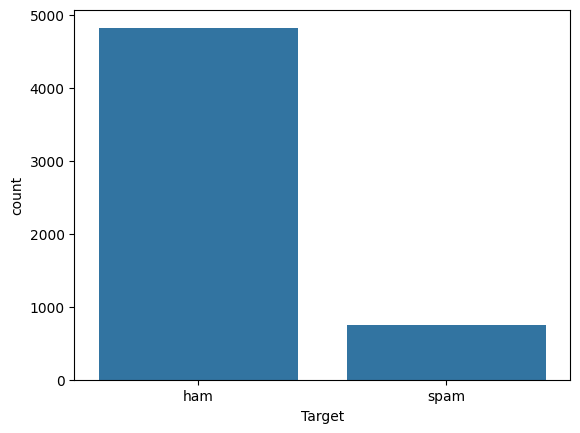

In [9]:
sns.countplot(data=df,x='Target')
plt.show()

In [10]:
print("Percentage of spams in our data is {}%".format(round(df.Target.value_counts()[1]/len(df.Target)*100, 2)))


Percentage of spams in our data is 13.41%


<ipython-input-10-55079330b030>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage of spams in our data is {}%".format(round(df.Target.value_counts()[1]/len(df.Target)*100, 2)))


The dataset is imbalanced, yet it remains a large enough sample to get interesting results.

## PREPROCESSING

### Spacy

In [11]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [12]:
# Using spacy library :
nlp = spacy.load('en_core_web_sm')

In [13]:
# Remove all non alphanumeric characters except whitespaces :
df["text_clean"] = df["Text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# removing double spaces and spaces at the beginning and end of strings :
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# removing stop words and replacing every word with their lemma :
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [14]:
# Labeling the target column :
df['Target_value'] = df['Target'].map({'ham':0,'spam':1})

In [15]:
df.head()

,Target,Text,text_clean,Target_value
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


### WordCloud

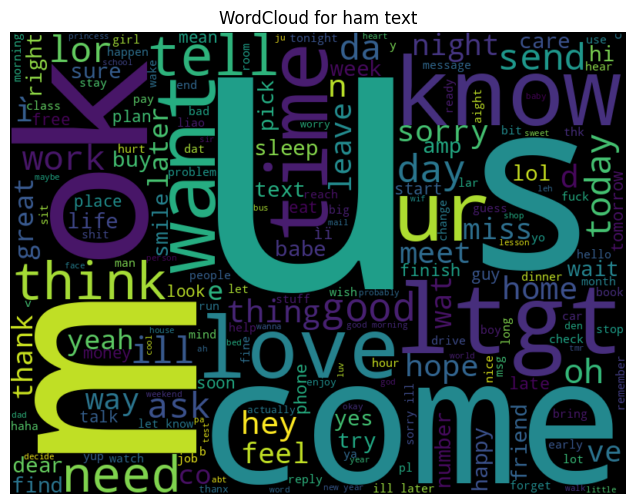

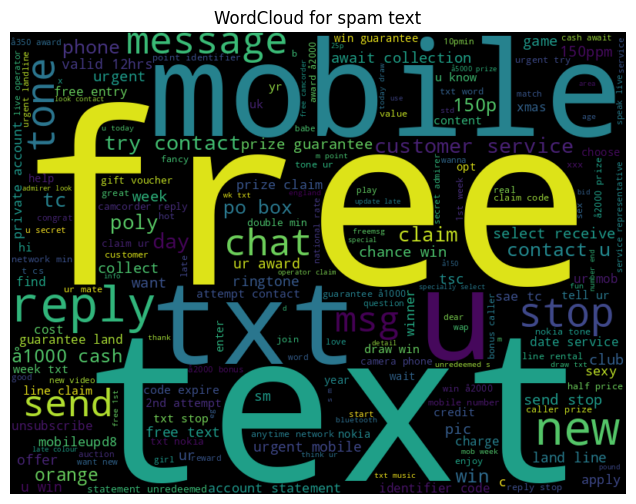

In [16]:
# Generate and display word clouds for each target category
for target in df['Target'].unique():
    words = ' '.join(df[df['Target'] == target]['text_clean'])
    wordcloud = WordCloud(width=800, height=600).generate(words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for {target} text")
    plt.axis('off')
    plt.show()

### Tokenization

In [17]:
# Tokenize using TensorFlow's Tokenizer
max_words = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df['text_clean'])
df["text_tokenized"] = tokenizer.texts_to_sequences(df['text_clean'])

df.head()

,Target,Text,text_clean,Target_value,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 230, 446, 462, 941, 36, 52, 204, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[13, 299, 4, 532, 663, 34, 1453, 850, 422, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 150, 2353, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[708, 23, 664, 129]"


### Padding

In [18]:
# Apply padding to the tokenized text :
text_padded = tf.keras.preprocessing.sequence.pad_sequences(df["text_tokenized"], padding="post")

text_padded

array([[   1,  230,  446, ...,    0,    0,    0],
       [  10,  195,  463, ...,    0,    0,    0],
       [  13,  299,    4, ...,    0,    0,    0],
       ...,
       [   1,  936,    1, ...,    0,    0,    0],
       [ 113,    1, 1589, ...,    0,    0,    0],
       [2074,  319,    0, ...,    0,    0,    0]], dtype=int32)

In [19]:
text_padded.shape

(5572, 72)

The length of the texts in our dataset is now 72

### Train_Test Split

In [20]:
# Splitting into train and val sets :
X_train, X_val, y_train, y_val = train_test_split(text_padded,df['Target_value'], test_size=0.3)

In [21]:
# Convert to TensorFlow Dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch the datasets
batch_size = 64
train_batch = train.shuffle(buffer_size=len(train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_batch = val.shuffle(buffer_size=len(val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
# Let's take a look at a batch
for text, value in train_batch.take(1):
  print(text, value)

tf.Tensor(
[[ 271   40   42 ...    0    0    0]
 [  13  205   37 ...    0    0    0]
 [ 170  804  283 ...    0    0    0]
 ...
 [ 118  706   24 ...    0    0    0]
 [   1 1159    2 ...    0    0    0]
 [  68   47 1156 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0], shape=(64,), dtype=int64)


In [23]:
text.shape

TensorShape([64, 72])

## Training model

#### First model : Simple model


In [24]:
vocab_size = tokenizer.num_words
embedding_dim= 16
model = Sequential([
                  Embedding(vocab_size+1, embedding_dim,input_shape=[text.shape[1],], name="embedding"), # +1 for the padding value 0
                  GlobalAveragePooling1D(),
                  Dense(64, activation='relu'),
                  Dense(32, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            48016     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [26]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
#Fitting the model
history = model.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 11s 129ms/step - loss: 0.5769 - accuracy: 0.8633 - val_loss: 0.3847 - val_accuracy: 0.8726
Epoch 2/50
61/61 [==============================] - 4s 59ms/step - loss: 0.3733 - accuracy: 0.8631 - val_loss: 0.3477 - val_accuracy: 0.8726
Epoch 3/50
61/61 [==============================] - 3s 46ms/step - loss: 0.3494 - accuracy: 0.8631 - val_loss: 0.3201 - val_accuracy: 0.8726
Epoch 4/50
61/61 [==============================] - 2s 36ms/step - loss: 0.3063 - accuracy: 0.8631 - val_loss: 0.2592 - val_accuracy: 0.8726
Epoch 5/50
61/61 [==============================] - 1s 21ms/step - loss: 0.1942 - accuracy: 0.9108 - val_loss: 0.1308 - val_accuracy: 0.9593
Epoch 6/50
61/61 [==============================] - 1s 20ms/step - loss: 0.0906 - accuracy: 0.9731 - val_loss: 0.0834 - val_accuracy: 0.9731
Epoch 7/50
61/61 [==============================] - 1s 12ms/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 0.0670 - val_accuracy: 0.9803
Epoch 8/50


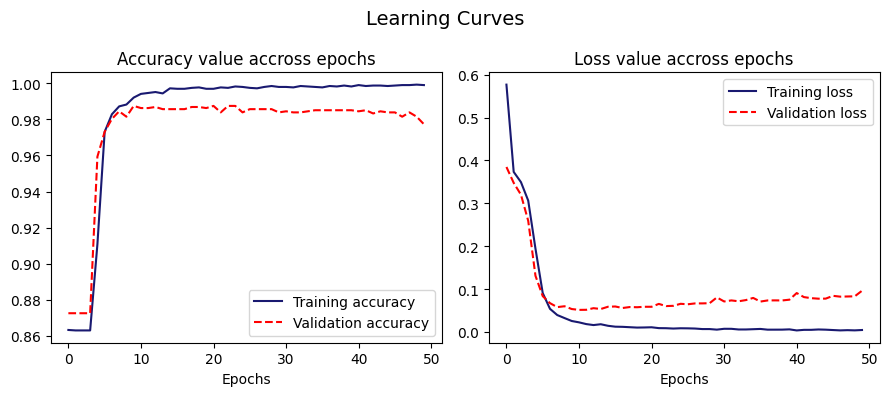

In [28]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_batch)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

27/27 [==============================] - 0s 2ms/step - loss: 0.0959 - accuracy: 0.9773
Validation Loss: 0.09593387693166733
Validation Accuracy: 0.9772727489471436


Training Accuracy: The training accuracy increases rapidly and stabilizes near 1.0, indicating that the model has learned the training data well.
Validation Accuracy: The validation accuracy reaches around 0.98 and remains relatively stable, with slight fluctuations. This shows that the model generalizes well to the validation data, but the fluctuations suggest that there might still be room for improvement in terms of stability.

Training Loss: The training loss decreases quickly and stabilizes close to zero, which aligns with the high training accuracy.
Validation Loss: The validation loss initially decreases but stabilizes at a higher level compared to the training loss. Additionally, it shows a slight upward trend with some fluctuations towards the end of training, which could indicate mild overfitting.

The model shows good overall performance, with high accuracy on both the training and validation sets.
However, the higher and fluctuating validation loss compared to the training loss suggests that the model might be slightly overfitting.

In [62]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model1.keras')

#### Second model : LSTM :

In [31]:
# Defining the model :
model_lstm = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  LSTM(units=64, return_sequences=True),
                  LSTM(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [32]:
# Compile the model

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Training the model :
history_lstm=model_lstm.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 9s 93ms/step - loss: 0.4592 - accuracy: 0.8513 - val_loss: 0.3826 - val_accuracy: 0.8726
Epoch 2/50
61/61 [==============================] - 3s 44ms/step - loss: 0.4000 - accuracy: 0.8631 - val_loss: 0.3814 - val_accuracy: 0.8726
Epoch 3/50
61/61 [==============================] - 2s 36ms/step - loss: 0.4004 - accuracy: 0.8631 - val_loss: 0.3817 - val_accuracy: 0.8726
Epoch 4/50
61/61 [==============================] - 2s 33ms/step - loss: 0.4002 - accuracy: 0.8631 - val_loss: 0.3824 - val_accuracy: 0.8726
Epoch 5/50
61/61 [==============================] - 1s 14ms/step - loss: 0.4006 - accuracy: 0.8631 - val_loss: 0.3863 - val_accuracy: 0.8726
Epoch 6/50
61/61 [==============================] - 1s 17ms/step - loss: 0.3998 - accuracy: 0.8631 - val_loss: 0.3837 - val_accuracy: 0.8726
Epoch 7/50
61/61 [==============================] - 1s 19ms/step - loss: 0.3997 - accuracy: 0.8631 - val_loss: 0.3818 - val_accuracy: 0.8726
Epoch 8/50
61

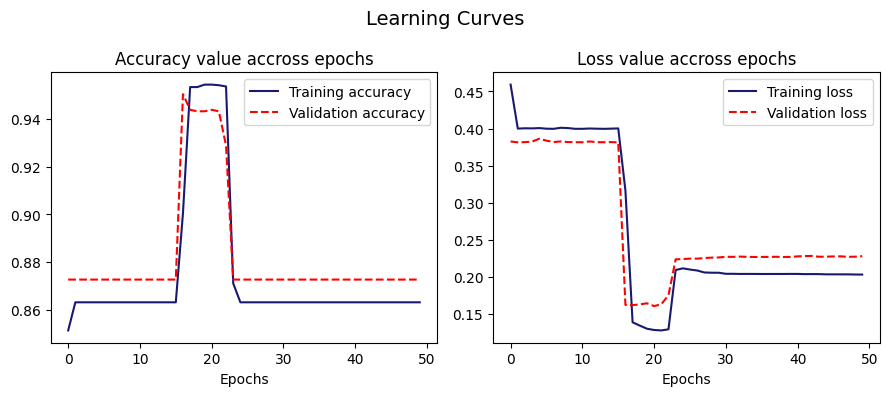

In [34]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_lstm.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_lstm.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_lstm.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_lstm.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [35]:
# Evaluate the model
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(val_batch)
print(f"Validation Loss: {val_loss_lstm}")
print(f"Validation Accuracy: {val_accuracy_lstm}")

27/27 [==============================] - 0s 4ms/step - loss: 0.2279 - accuracy: 0.8726
Validation Loss: 0.22790983319282532
Validation Accuracy: 0.8726076483726501


Training Accuracy: The training accuracy shows a sharp increase around epoch 20 but then drops back down and remains flat. This sudden spike followed by a drop indicates that the model might be encountering instability during training. This could be due to factors like an improper learning rate, batch size issues, or weight initialization problems.
Validation Accuracy: Similarly, the validation accuracy follows the same pattern, with a sharp increase followed by a drop and then leveling off. This mirrors the behavior of the training accuracy, reinforcing the idea that the training process is unstable.

Training Loss: The training loss decreases significantly around epoch 20, coinciding with the spike in accuracy, but then it also drops sharply. The loss then remains flat, which aligns with the accuracy pattern. This suggests that the model is either overfitting or underfitting after the sharp change in training dynamics.
Validation Loss: The validation loss shows a similar pattern, with a significant drop around epoch 20, followed by fluctuations and then stabilization at a higher level than the training loss. This indicates that the model is not generalizing well and could be struggling to learn consistently.

The sharp spikes and drops in both accuracy and loss suggest instability in the training process.

In conclusion, this model's learning curves indicate significant instability

In [63]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model2.keras')

#### Third model : Simple RNN :

In [37]:
# Defining the model :
model_rnn = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  SimpleRNN(units=16, return_sequences=True),
                  SimpleRNN(units=8, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [38]:
# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
# Training the model :
history_rnn=model_rnn.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 14s 177ms/step - loss: 0.4378 - accuracy: 0.8610 - val_loss: 0.3213 - val_accuracy: 0.8983
Epoch 2/50
61/61 [==============================] - 9s 144ms/step - loss: 0.2006 - accuracy: 0.9377 - val_loss: 0.1360 - val_accuracy: 0.9617
Epoch 3/50
61/61 [==============================] - 8s 129ms/step - loss: 0.0834 - accuracy: 0.9805 - val_loss: 0.1234 - val_accuracy: 0.9689
Epoch 4/50
61/61 [==============================] - 7s 115ms/step - loss: 0.0601 - accuracy: 0.9864 - val_loss: 0.0874 - val_accuracy: 0.9803
Epoch 5/50
61/61 [==============================] - 6s 101ms/step - loss: 0.0466 - accuracy: 0.9885 - val_loss: 0.1207 - val_accuracy: 0.9653
Epoch 6/50
61/61 [==============================] - 7s 107ms/step - loss: 0.0364 - accuracy: 0.9908 - val_loss: 0.0807 - val_accuracy: 0.9791
Epoch 7/50
61/61 [==============================] - 7s 115ms/step - loss: 0.0268 - accuracy: 0.9938 - val_loss: 0.0895 - val_accuracy: 0.9815
Epoch

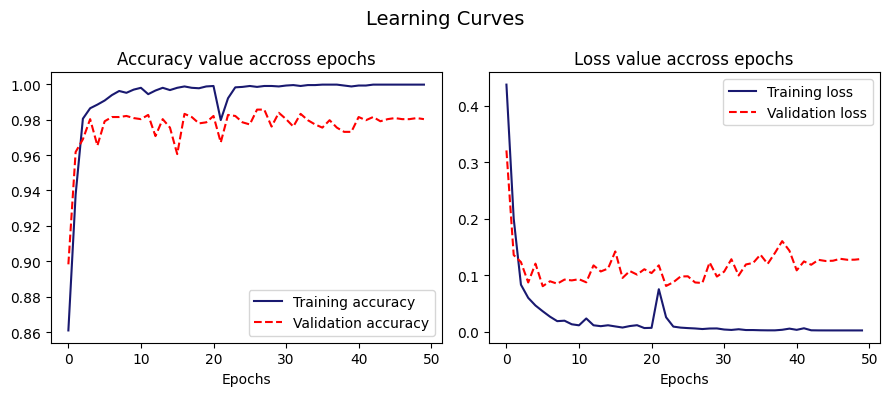

In [40]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_rnn.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_rnn.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [41]:
# Evaluate the model
val_loss_rnn, val_accuracy_rnn = model_rnn.evaluate(val_batch)
print(f"Validation Loss: {val_loss_rnn}")
print(f"Validation Accuracy: {val_accuracy_rnn}")

27/27 [==============================] - 0s 13ms/step - loss: 0.1291 - accuracy: 0.9803
Validation Loss: 0.1291244775056839
Validation Accuracy: 0.9802631735801697


Training Accuracy: The training accuracy increases rapidly and stabilizes near 1.0, indicating that the model is effectively learning from the training data.
Validation Accuracy: The validation accuracy, while high, shows considerable fluctuations throughout the epochs, ranging between 0.96 and 0.98. These fluctuations indicate that the model's performance on the validation data is unstable, which could be a sign of overfitting or sensitivity to the validation data.

Training Loss: The training loss decreases sharply and stabilizes close to zero, which is consistent with the high training accuracy.
Validation Loss: The validation loss decreases initially but then shows fluctuations and does not decrease as consistently as the training loss. The fluctuations in validation loss are more pronounced, which again suggests that the model may be overfitting to the training data or is having difficulty generalizing to the validation data.

The model shows signs of overfitting, as indicated by the high training accuracy and low training loss, coupled with fluctuating validation accuracy and loss. Overfitting occurs when a model performs very well on the training data but struggles to generalize to new, unseen data (in this case, the validation set).

In [42]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model3.keras')

#### Fourth model : GRU :

In [43]:
# Defining the model :
model_gru = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  GRU(units=64, return_sequences=True),
                  GRU(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [44]:
# Compile the model
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
# Training the model :
history_gru=model_gru.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 9s 92ms/step - loss: 0.4627 - accuracy: 0.8487 - val_loss: 0.3861 - val_accuracy: 0.8726
Epoch 2/50
61/61 [==============================] - 3s 52ms/step - loss: 0.4017 - accuracy: 0.8631 - val_loss: 0.3844 - val_accuracy: 0.8726
Epoch 3/50
61/61 [==============================] - 1s 25ms/step - loss: 0.4003 - accuracy: 0.8631 - val_loss: 0.3823 - val_accuracy: 0.8726
Epoch 4/50
61/61 [==============================] - 2s 28ms/step - loss: 0.4015 - accuracy: 0.8631 - val_loss: 0.3814 - val_accuracy: 0.8726
Epoch 5/50
61/61 [==============================] - 1s 25ms/step - loss: 0.4004 - accuracy: 0.8631 - val_loss: 0.3840 - val_accuracy: 0.8726
Epoch 6/50
61/61 [==============================] - 1s 21ms/step - loss: 0.3999 - accuracy: 0.8631 - val_loss: 0.3816 - val_accuracy: 0.8726
Epoch 7/50
61/61 [==============================] - 1s 17ms/step - loss: 0.4002 - accuracy: 0.8631 - val_loss: 0.3821 - val_accuracy: 0.8726
Epoch 8/50
61

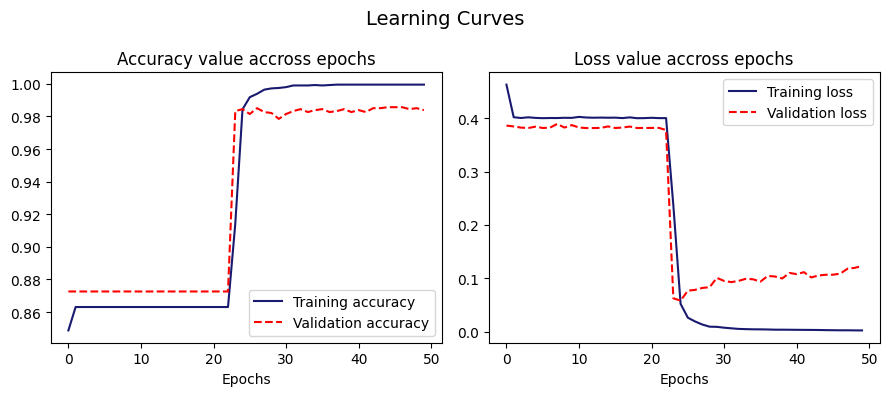

In [46]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_gru.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_gru.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_gru.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_gru.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [47]:
# Evaluate the model
val_loss_gru, val_accuracy_gru = model_gru.evaluate(val_batch)
print(f"Validation Loss: {val_loss_gru}")
print(f"Validation Accuracy: {val_accuracy_gru}")

27/27 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9839
Validation Loss: 0.12326349318027496
Validation Accuracy: 0.9838516712188721


Training Accuracy: The training accuracy increases sharply around epoch 20 and quickly stabilizes near 1.0, indicating that the model is effectively learning from the training data.
Validation Accuracy: The validation accuracy also improves significantly after epoch 20, stabilizing around 0.98. This suggests that the model generalizes well to the validation data. However, both training and validation accuracies remain flat before epoch 20, indicating that the model was not learning effectively during the initial epochs.

Training Loss: The training loss drops sharply after epoch 20, aligning with the increase in training accuracy. This suggests that the model undergoes a significant improvement in learning after this point. The loss stabilizes close to zero, which corresponds to the high training accuracy.
Validation Loss: The validation loss follows a similar pattern, decreasing sharply after epoch 20 and stabilizing at a higher level compared to the training loss. However, the validation loss shows some fluctuations even after the sharp drop, indicating that while the model performs well on the validation data, it may still struggle with some variability in generalization.

Delayed Learning: The sharp improvement after epoch 20 suggests that the model might have undergone a learning rate adjustment or another change in training dynamics that led to this sudden learning.
Overfitting: The gap between training loss and validation loss, although small, suggests potential overfitting, where the model performs slightly better on training data compared to validation data.

In [48]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model4.keras')

#### Fifth Model: CNN:

In [49]:
# Defining the model
vocab_size = tokenizer.num_words  # Taille du vocabulaire
embedding_dim = 8  # Dimension de l'espace de représentation

num_filters = 128  # Nombre de filtres pour la couche de convolution
kernel_size = 5  # Taille du noyau de convolution

model_cnn = Sequential([
    Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=[text.shape[1],], name="embedding"),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),  # Même dimension que le modèle simple
    Dense(1, activation='sigmoid')
])

In [50]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 8)             24008     
                                                                 
 conv1d (Conv1D)             (None, 68, 128)           5248      
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 31337 (122.41 KB)
Trainable params: 31337 (122.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [51]:
# Compile the model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
# Fitting the model
history_cnn = model_cnn.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 10s 136ms/step - loss: 0.4636 - accuracy: 0.8631 - val_loss: 0.3720 - val_accuracy: 0.8726
Epoch 2/50
61/61 [==============================] - 4s 66ms/step - loss: 0.3163 - accuracy: 0.8631 - val_loss: 0.1810 - val_accuracy: 0.8726
Epoch 3/50
61/61 [==============================] - 3s 46ms/step - loss: 0.1250 - accuracy: 0.9510 - val_loss: 0.0906 - val_accuracy: 0.9844
Epoch 4/50
61/61 [==============================] - 1s 21ms/step - loss: 0.0487 - accuracy: 0.9900 - val_loss: 0.0614 - val_accuracy: 0.9850
Epoch 5/50
61/61 [==============================] - 1s 23ms/step - loss: 0.0248 - accuracy: 0.9944 - val_loss: 0.0576 - val_accuracy: 0.9833
Epoch 6/50
61/61 [==============================] - 1s 20ms/step - loss: 0.0162 - accuracy: 0.9974 - val_loss: 0.0530 - val_accuracy: 0.9850
Epoch 7/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0127 - accuracy: 0.9974 - val_loss: 0.0537 - val_accuracy: 0.9839
Epoch 8/50


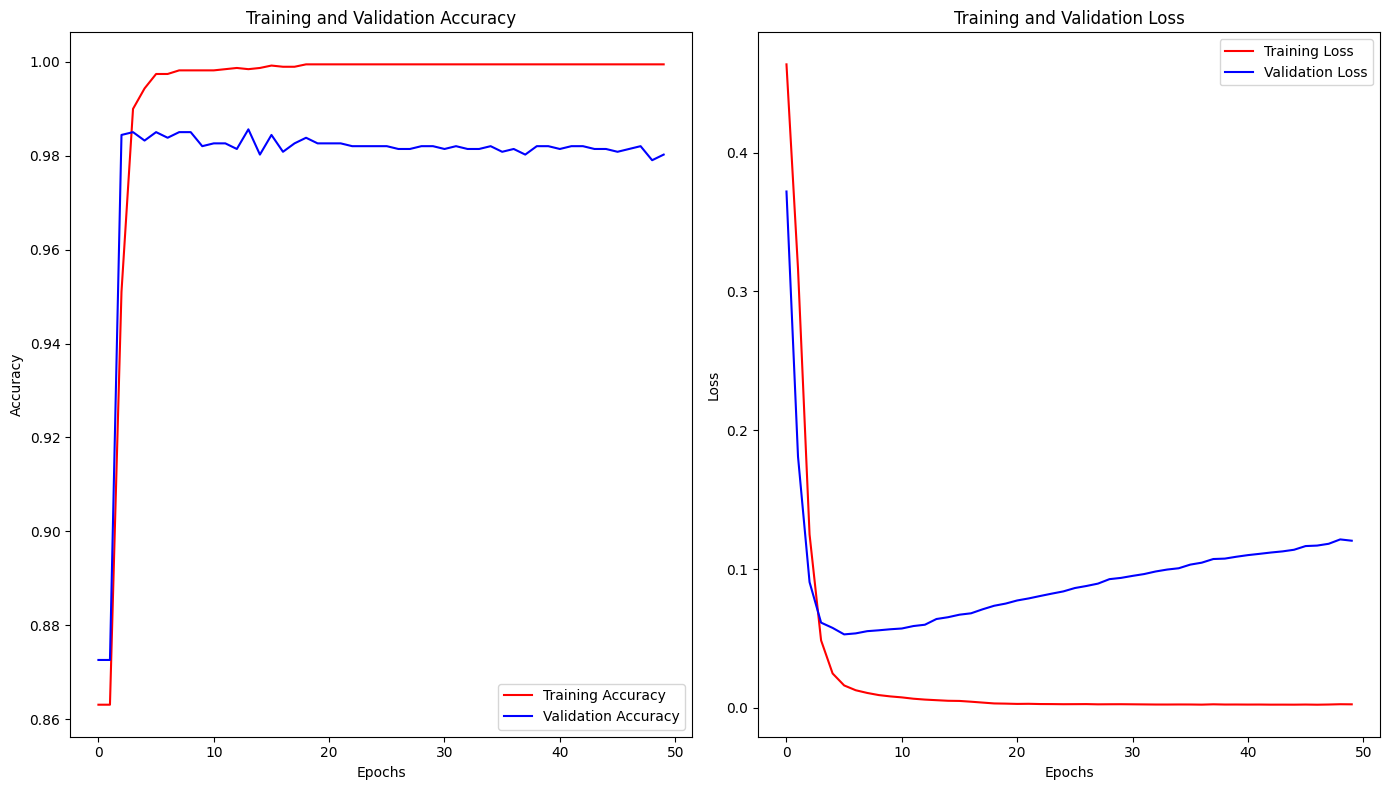

In [53]:
# Plotting accuracy & loss

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))


plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' pour ligne rouge continue
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')  # 'b-' pour ligne bleue continue
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')  # 'r-' pour ligne rouge continue
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')  # 'b-' pour ligne bleue continue
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
# Évaluer le modèle
val_loss_cnn, val_accuracy_cnn = model_cnn.evaluate(val_batch)
print(f"Validation Loss: {val_loss_cnn}")
print(f"Validation Accuracy: {val_accuracy_cnn}")


27/27 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9803
Validation Loss: 0.12045469135046005
Validation Accuracy: 0.9802631735801697


Training Accuracy: The training accuracy quickly rises and stabilizes near 1.0, indicating that the model has learned the training data very well.
Validation Accuracy: The validation accuracy also reaches a high level, stabilizing around 0.98. However, there are slight fluctuations in the validation accuracy across the epochs, which suggests that the model might not be perfectly stable on the validation data. Despite these fluctuations, the validation accuracy remains consistently high, indicating good generalization.

Training Loss: The training loss decreases sharply and flattens near zero, which is consistent with the high training accuracy. This indicates that the model is effectively minimizing the loss on the training data.
Validation Loss: The validation loss also decreases significantly initially, but after reaching a minimum, it begins to increase steadily across the epochs. This rising validation loss, despite stable validation accuracy, suggests that the model may be overfitting to the training data. The model continues to perform well on the validation data in terms of accuracy, but the increasing loss indicates that it might be capturing noise or becoming too specialized to the training data.

Overfitting: The model demonstrates signs of overfitting, as seen by the increasing validation loss, even though the validation accuracy remains high. Overfitting occurs when the model performs well on the training data but starts to perform worse on unseen data, which is suggested by the rising validation loss.

In [55]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model5.keras')

#### Transfer learning - BERT :

In [56]:
!pip install --upgrade tensorflow_hub

In [57]:
#installing tensorflow_text
!pip install tensorflow_text=='2.15.0'

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4

In [56]:
df.head()

,Target,Text,text_clean,Target_value,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 230, 446, 462, 941, 36, 52, 204, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[13, 299, 4, 532, 663, 34, 1453, 850, 422, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 150, 2353, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[708, 23, 664, 129]"


In [57]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], df['Target_value'], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [58]:
import tensorflow_hub as hub
import tensorflow_text

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

out = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
out = tf.keras.layers.Dense(16,activation='relu')(out)
out = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(out)

model_bert=tf.keras.Model(inputs=[text_input],outputs=[out])

model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bert = model_bert.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 16s 182ms/step - loss: 0.3484 - accuracy: 0.8336 - val_loss: 0.2133 - val_accuracy: 0.8870
Epoch 2/50
61/61 [==============================] - 11s 177ms/step - loss: 0.2042 - accuracy: 0.9154 - val_loss: 0.1616 - val_accuracy: 0.9396
Epoch 3/50
61/61 [==============================] - 11s 178ms/step - loss: 0.1652 - accuracy: 0.9364 - val_loss: 0.1496 - val_accuracy: 0.9432
Epoch 4/50
61/61 [==============================] - 11s 176ms/step - loss: 0.1516 - accuracy: 0.9472 - val_loss: 0.1369 - val_accuracy: 0.9522
Epoch 5/50
61/61 [==============================] - 11s 177ms/step - loss: 0.1487 - accuracy: 0.9451 - val_loss: 0.1343 - val_accuracy: 0.9492
Epoch 6/50
61/61 [==============================] - 11s 176ms/step - loss: 0.1365 - accuracy: 0.9479 - val_loss: 0.1270 - val_accuracy: 0.9522
Epoch 7/50
61/61 [==============================] - 11s 177ms/step - loss: 0.1360 - accuracy: 0.9508 - val_loss: 0.1256 - val_accuracy: 0.9545

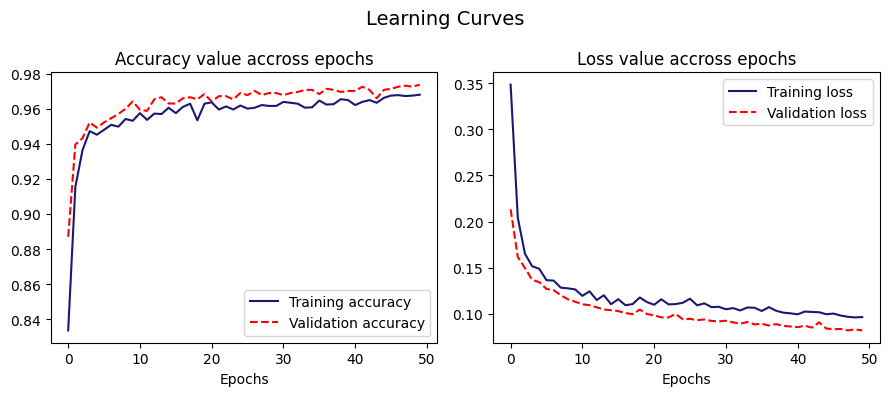

In [59]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_bert.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_bert.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_bert.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_bert.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [60]:
# Evaluate the model
val_loss_bert, val_accuracy_bert = model_bert.evaluate(val_batch)
print(f"Validation Loss: {val_loss_bert}")
print(f"Validation Accuracy: {val_accuracy_bert}")

27/27 [==============================] - 3s 123ms/step - loss: 0.0820 - accuracy: 0.9737
Validation Loss: 0.08200165629386902
Validation Accuracy: 0.9736841917037964


Training Accuracy: The training accuracy rises quickly and stabilizes around 0.96. This indicates that the model is learning the training data well but is not overfitting excessively.
Validation Accuracy: The validation accuracy also stabilizes around 0.95, but it shows some fluctuations throughout the training process. These fluctuations suggest that the model's performance on the validation set is not entirely stable, although it remains consistently high.

Training Loss: The training loss decreases sharply and continues to decline steadily over the epochs. This behavior is expected as the model minimizes the error on the training data.
Validation Loss: The validation loss follows a similar pattern but shows more fluctuations compared to the training loss. Although the validation loss is relatively low, the fluctuations suggest that the model may be slightly overfitting or is sensitive to the validation data.

Generalization: The model generalizes well, with high accuracy on both training and validation sets. However, the fluctuations in validation accuracy and loss indicate that the model might benefit from further regularization or fine-tuning.
Stability: The slight instability in the validation metrics suggests that the model could be sensitive to the specific batches of validation data. Techniques such as dropout, data augmentation, or adjusting the learning rate might help improve the model's stability.
Overfitting: Although the signs of overfitting are not severe, the difference between training and validation loss and the fluctuations in validation accuracy suggest that some overfitting may be occurring.

In [61]:
# saving the model :
model.save('/content/drive/MyDrive/Projets RNCP/Block 4/AT&T/spam_detector_model6.keras')

## RESULTS

In [66]:
# Creating a DataFrame with the results
results = pd.DataFrame({'Simple Model': [val_accuracy,0.0959],
                        'LSTM model': [val_accuracy_lstm, val_loss_lstm],
                        'Simple RNN model': [val_accuracy_rnn, val_loss_rnn],
                        'GRU model': [val_accuracy_gru, val_loss_gru],
                        'Bert model':[val_accuracy_bert,val_loss_bert],
                        'CNN model': [val_accuracy_cnn,val_loss_cnn]},
                                      index=['Accuracy','Loss'])

results.T

,Accuracy,Loss
Simple Model,0.977273,0.095900
LSTM model,0.872608,0.227910
Simple RNN model,0.980263,0.129124
GRU model,0.983852,0.123263
Bert model,0.973684,0.082002
CNN model,0.980263,0.120455


# Conclusion :

Top Performers: The GRU and CNN models have the highest accuracy, with GRU slightly edging out in terms of lower loss. Both models generalize well and maintain a balance between accuracy and minimizing loss.

BERT also stands out with the lowest loss, making it an excellent choice for complex tasks that require a deep understanding of the data.

Simple RNN is also a strong performer, though it has a slightly higher loss compared to the top models.

Simple Model performs well but may require further tuning to match the robustness of the top models.

LSTM lags behind the other models and may need significant improvements in tuning or architecture to perform better.

In summary, the GRU, CNN, and BERT models are the best choices based on these metrics, with GRU having a slight edge in accuracy and BERT in loss minimization.